# Equation of state plots

## Setup

In [12]:
# for formatting specific to this thesis
using ThesisUtils

# for plotting
using Plots
using StatPlots  # lets us plot DataFrames
using LaTeXStrings
using Colors

# for handling tables of data
using DataFrames
using FileIO
using CSVFiles
using IterableTables

readdf(file; kwargs...) = DataFrame(load(file; kwargs...))

# pull in the EOS data
using WaterData

eosdata = WaterData.load_full_eos()
eosraw = eosdata["raw"]
eosgrid = eosdata["grid"]
phaseboundaries = WaterData.load_phase_boundaries()["boundaries"]
evapboundary = phaseboundaries["iapws"]
otherboundaries = phaseboundaries["dunaeva"]
tfd = WaterData.load_functional_eoses()["seager"]["h2o_tfd"]

minP, maxP = extrema(eosgrid.P)
minT, maxT = extrema(eosgrid.T);

# define how to plot phase boundaries
@recipe function plot(b::WaterData.PhaseBoundary)
    seriestype := :line
    linewidth --> 1
    label --> ""
    
    P = clamp.(b.P, eps(), Inf)
    T = clamp.(b.T, eps(), Inf)

    P, T
end

# map (P, T) pairs to colors according to the dataset they come from
getphase(P, T) = WaterData.extracteos(eosraw, P, T)
eos_strings = ["iapws", "sugimura", "french", "I", "III", 
    "V", "VI", "VII", "iapws", "X", "X", "iapws", "iapws",
    "iapws", "fallback"]

pdict = Dict()
for (eos, phase) in zip(eosraw.eoses, eos_strings)
    if eos ∉ keys(pdict)
        pdict[eos] = phase
    end
end

phases = Matrix{String}(256,256)
density = Matrix(256, 256)
for (iT, T) in enumerate(eosgrid.T), (iP, P) in enumerate(eosgrid.P)
    phase = getphase(P, T)
    phasestr = pdict[phase]
    density[iT, iP] = eosgrid(P, T)
    phases[iT, iP] = phasestr
end

## EOS sources

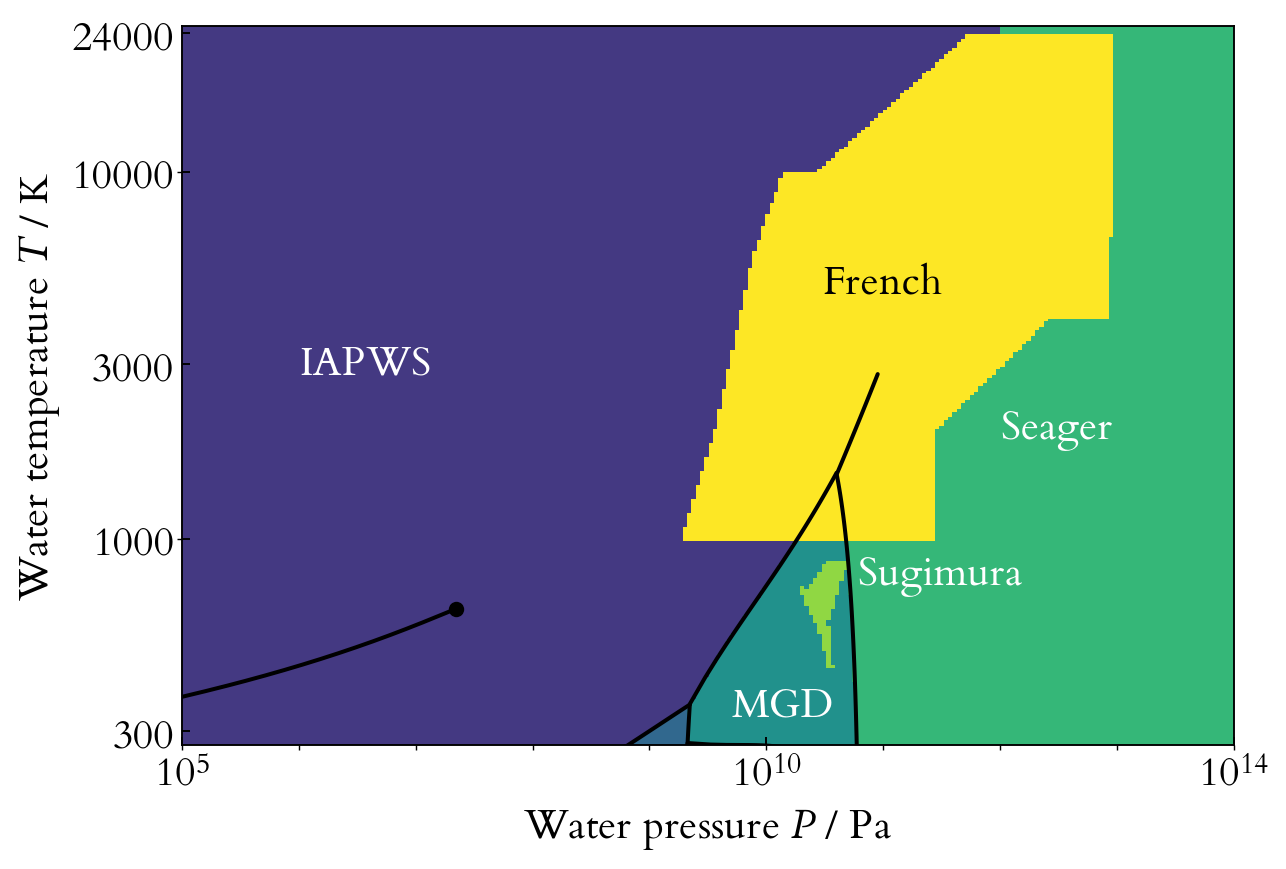

In [13]:
autofig("eos-phases", Normal, savepng=true) do
    palette = :viridis
    
    # axis formatting
    truncInt(y) = trunc(Int, y)
    scifmt(log10y) = LaTeXString("10\$^{$(log10y)}\$")
    xfmt(y) = log10(y) |> truncInt |> scifmt
    
    # plot the actual heatmap
    plot(xaxis=((1e5, maxP), :log10, L"Pressure $P$ / bar"),
        xticks=[1e5, 1e10, 1e14],
        yaxis=((minT, maxT), :log10, L"Temperature $T$ / K"),
        yticks=[300, 1000, 3000, 10000, 24000],
        yformatter=(y -> trunc(Int,y)), colorbar=false,
        framestyle = :box)
    heatmap!(eosgrid.P, eosgrid.T, phases, color = palette)
    
    # vapour curve
    plot!(evapboundary, 
        xaxis=(:log10, L"Water pressure $P$ / Pa"),
        yaxis=(:log10, L"Water temperature $T$ / K"),
        c=:black)
 
    # dot at critical point
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    scatter!([Pcrit], [Tcrit], label="", markersize=5, markerstrokewidth=0, c=:black)
    
    # phase boundaries
    plot!([1e5, 4.1e6], [2.7e2, 2.72e2], c=:black, label="")
    foreach(otherboundaries) do b
        plot!(b, linecolor = :black)
    end
    
    annotate_color!(1e6, 3e3, "IAPWS", :white)
    annotate_color!(3e10, 5e3, "French", :black)
    annotate_color!(1e12, 2e3, "Seager", :white)
    annotate_color!(5e9, 350, "MGD", :white)
    annotate_color!(6e10, 800, "Sugimura", :white)
end;

## EOS density

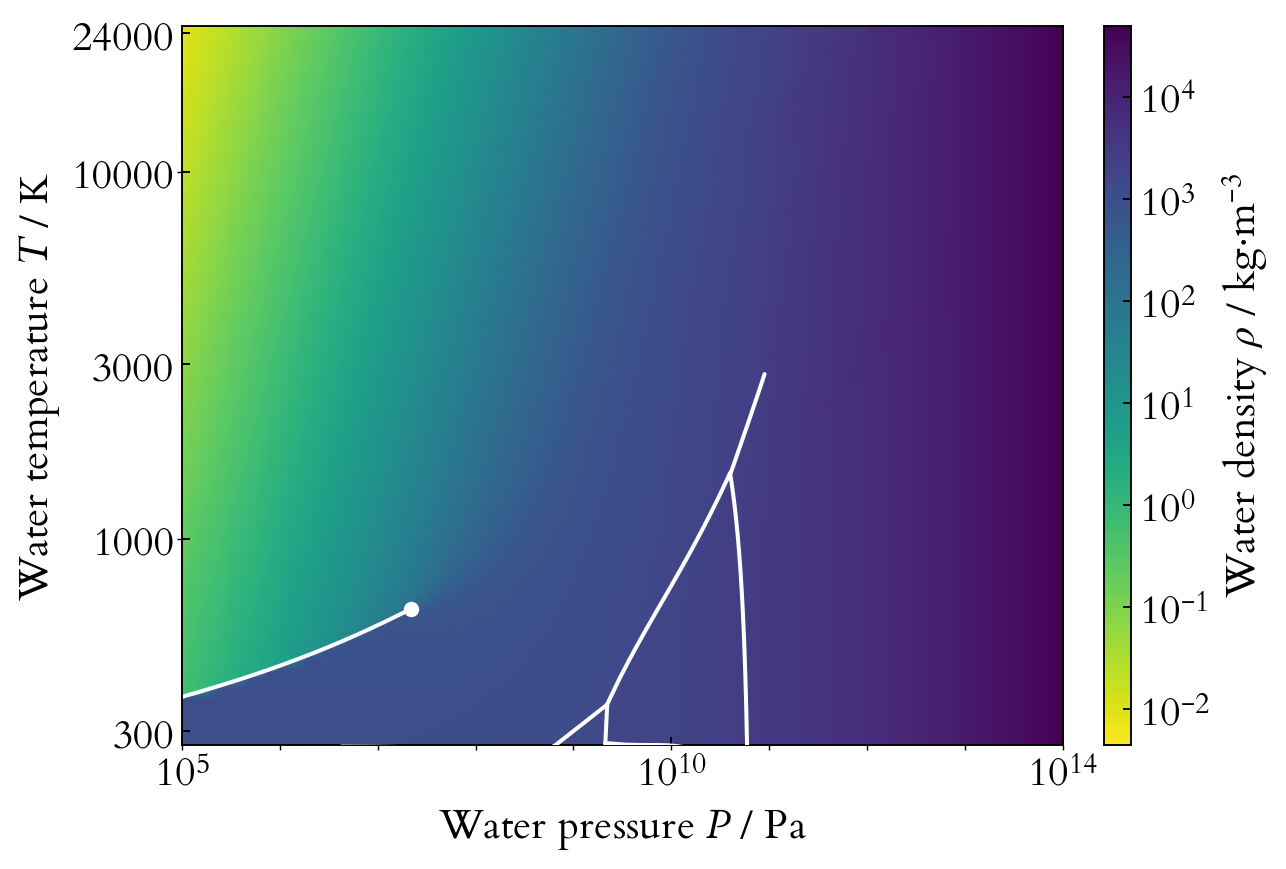

In [14]:
autofig("eos-density", Normal, savepng=true) do
    palette = :viridis_r
    
    # axis formatting
    truncInt(y) = trunc(Int, y)
    scifmt(log10y) = LaTeXString("10\$^{$(log10y)}\$")
    xfmt(y) = log10(y) |> truncInt |> scifmt
    densityfmt(log10ρ) = log10ρ |> truncInt |> scifmt
    
    # plot the actual heatmap
    x = eosgrid.P
    y = eosgrid.T
    z = log10.(density)
    eosplot = heatmap(x, y, z,
        xaxis=((1e5, maxP), :log10, L"Pressure $P$ / Pa"),
        xticks=[1e5, 1e10, 1e14],
        yaxis=((minT, maxT), :log10, L"Temperature $T$ / K"),
        yticks=[300, 1000, 3000, 10000, 24000],
        yformatter=(y -> trunc(Int,y)),
        color=palette, colorbar=false,
        framestyle = :box)
    
    # vapour curve
    plot!(evapboundary, 
        xaxis=(:log10, L"Water pressure $P$ / Pa"),
        yaxis=(:log10, L"Water temperature $T$ / K"),
        c=:white)
    
    # dot at critical point
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    scatter!([Pcrit], [Tcrit], label="", markersize=5, markerstrokewidth=0, c=:white)
    
    # phase boundaries
    plot!([1e5, 4.1e6], [2.7e2, 2.72e2], c=:black, label="")
    foreach(otherboundaries) do b
        plot!(b, c=:white)
    end
    
    # a colorbar
    Ncolors = 256
    span = 1:2
    grad = linspace(extrema(z)..., Ncolors)
    fill = hcat([grad for _ in span]...)
    cbar = heatmap(span, grad, fill, 
        colorbar=false, color=palette,
        framestyle = :box,
        xticks=nothing, 
        ymirror=true, 
        ylabel=L"Water density $ρ$ / kg$⋅$m$^{-3}$", 
        yformatter=densityfmt,
        yticks=-2:5)
    lay = @layout [ a b{0.03w} ]
    
    plot(eosplot, cbar, layout=lay)
end;

## EOS validation

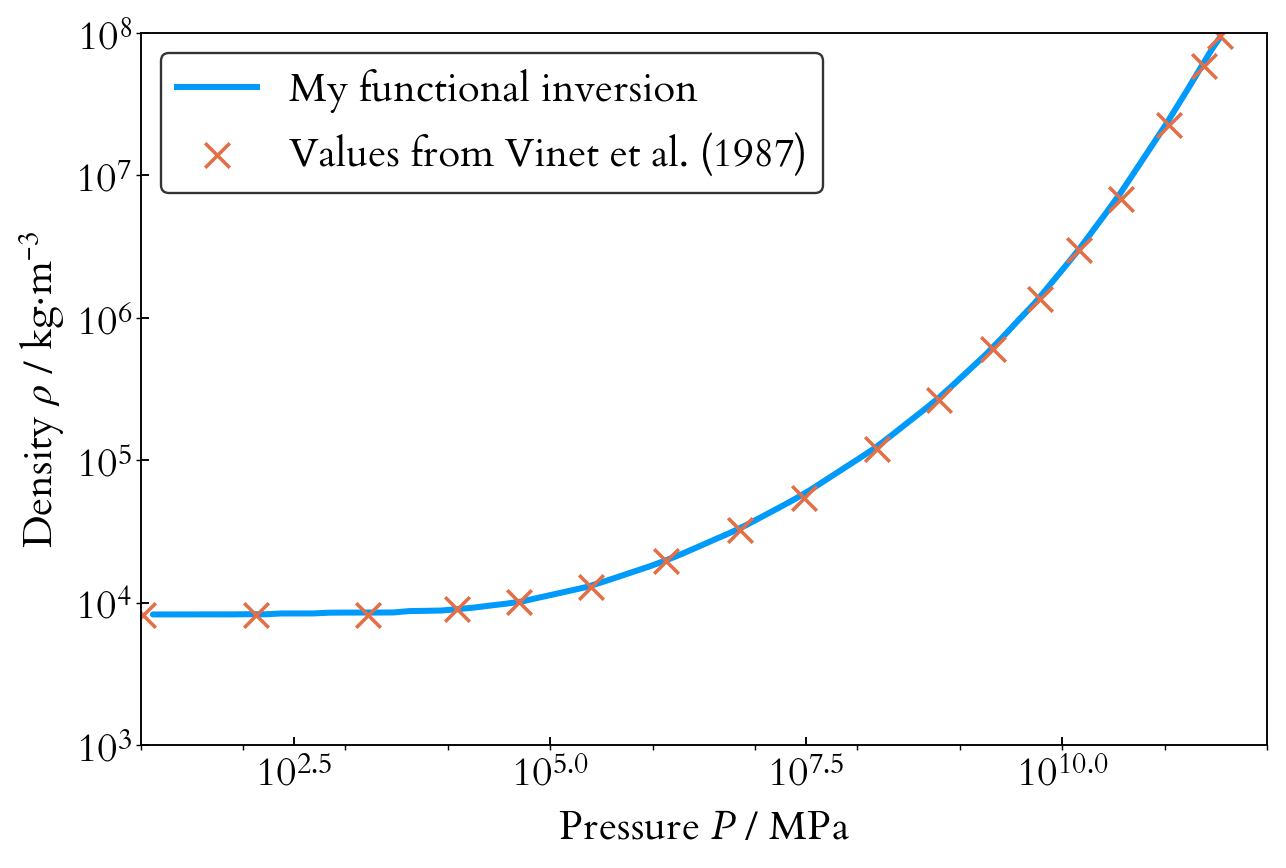

In [15]:
autofig("testing-functional-forms", Normal) do
    mine = readdf("figdata/raw/vinet-comparison/mine.csv", skiplines_begin = 1)
    vinet = readdf("figdata/raw/vinet-comparison/vinet.csv", skiplines_begin= 1)

    p = plot(framestyle = :box,
        xaxis=(:log10, L"Pressure $P$ / MPa", (1e1, 1e12)),
        yaxis=(:log10, L"Density $ρ$ / kg$⋅$m$^{-3}$", (1e3, 1e8)))
    mylabel = "My functional inversion"
    @df mine plot!(:pressure, :density, label=mylabel)
    marker = (:x, 8)
    vlabel = "Values from Vinet et al. (1987)"
    @df vinet scatter!(:pressure, :density, label=vlabel, marker=marker)

    p
end;

## EOS contours

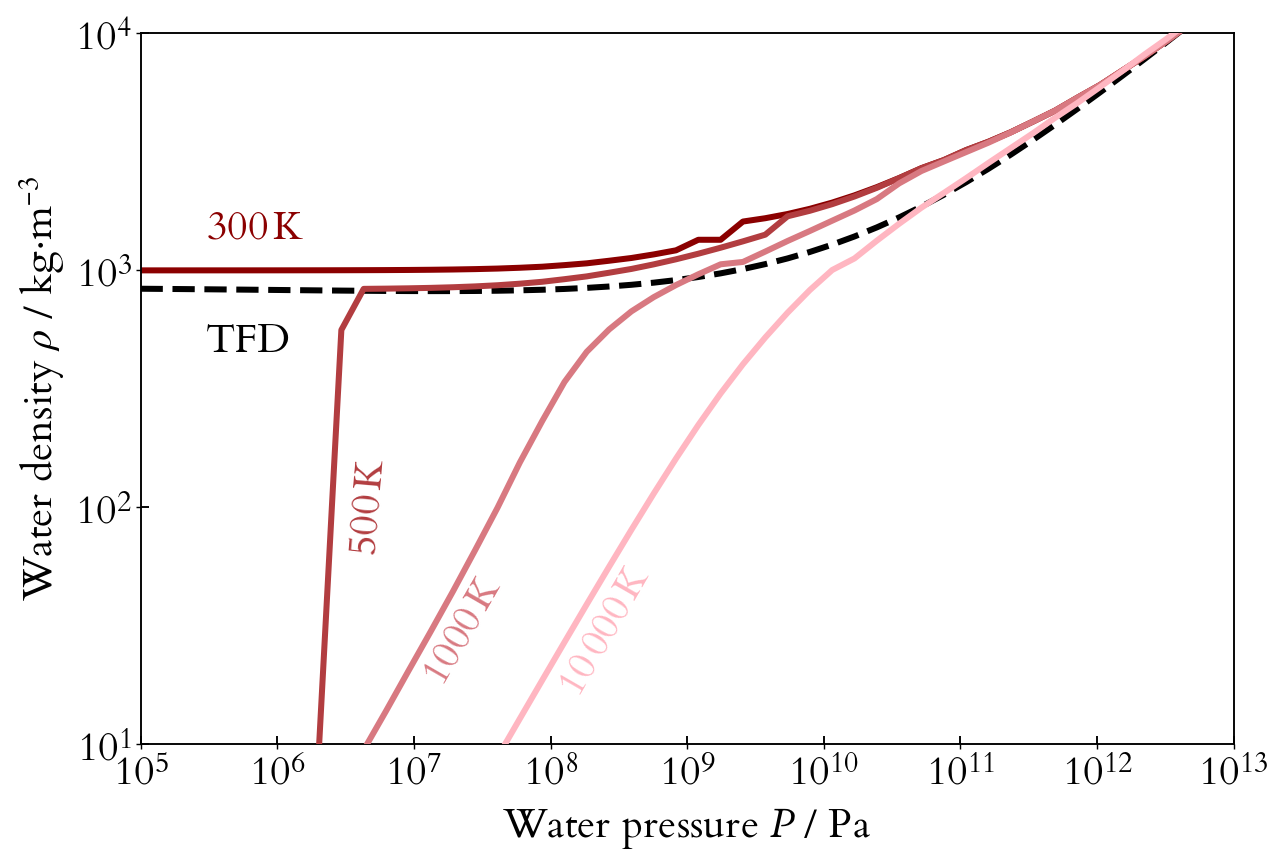

In [16]:
autofig("eos-contours", Normal) do
    Ps = logspace(5, 13)
    Ts = [300, 500, 1000, 10000]
    N = length(Ts)

    ρs = [eosgrid(P, T) for P in Ps, T in Ts]
    tfd_ρs = [tfd(P) for P in Ps]
    
    colors = seqcolors(:reds, N) |> reverse
    colors = reshape(colors, (1, N))
    
    plot(Ps, tfd_ρs, label="", c=:black, s=:dash, framestyle = :box)
    plot!(Ps, ρs, label="", c=colors) 
    
    xaxis!(:log10, (1e5, 1e13), L"Water pressure $P$ / Pa") 
    xticks!([10^n for n=5:13])
    yaxis!(:log10, (1e1, 1e4), L"Water density $ρ$ / kg$⋅$m$^{-3}$")
    yticks!([10^n for n=1:4])
    annotate_color!(3e5, 5e2, "TFD", :black)
    annotate_color!(3e5, 1.5*1e3, L"300$\,$K", colors[1])
    annotate_color!(3e6, 1e2, L"500$\,$K", colors[2], rotation=85)
    annotate_color!(1e7, 3e1, L"1000$\,$K", colors[3], rotation=60)
    annotate_color!(1e8, 3e1, L"10$\,$000$\,$K", colors[4], rotation=60)
end;

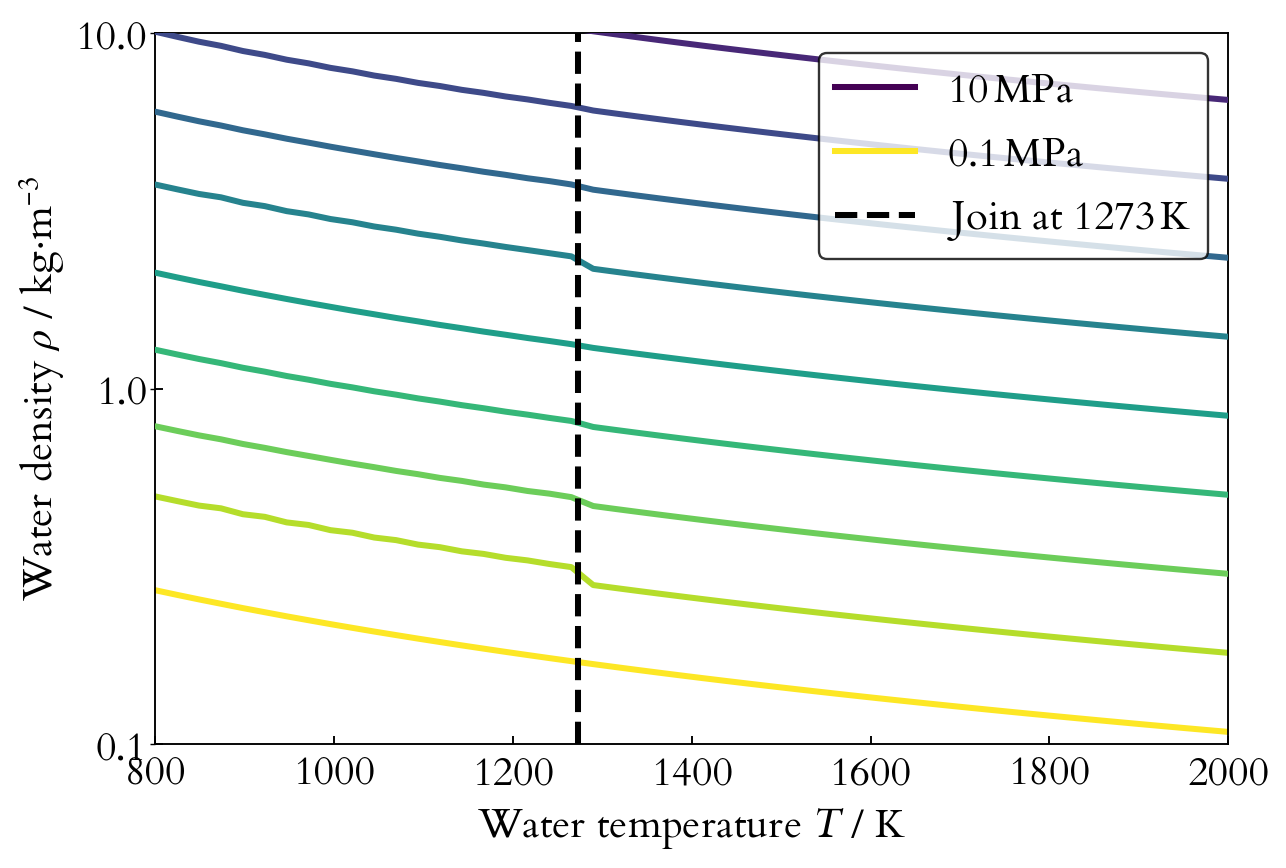

In [17]:
autofig("iapws-matching", Normal) do 
    Ts = linspace(800, 2000)
    N = 10
    Ps = logspace(5, 7, N)
    ρs = [eosraw(P, T) for T in Ts, P in Ps]
    
    colors = seqcolors(:viridis, N) |> reverse
    colors = reshape(colors, (1, N))

    ρfmt = ρ -> ρ

    plot(Ts, ρs, label="", 
        c=colors,
        framestyle = :box,
        legend=:topright,
        xlims=extrema(Ts),
        xlabel=L"Water temperature $T$ / K",
        yaxis=(:log10, L"Water density $ρ$ / kg$⋅$m$^{-3}$", ρfmt, (0.1, 10), [0.1, 1, 10]))
    plot!([-99], [-99], label=L"10$\,$MPa", c=colors[N])
    plot!([-99], [-99], label=L"0.1$\,$MPa", c=colors[1])
    vline!([1273], c=:black, s=:dash, label=L"Join at 1273$\,$K")
end;

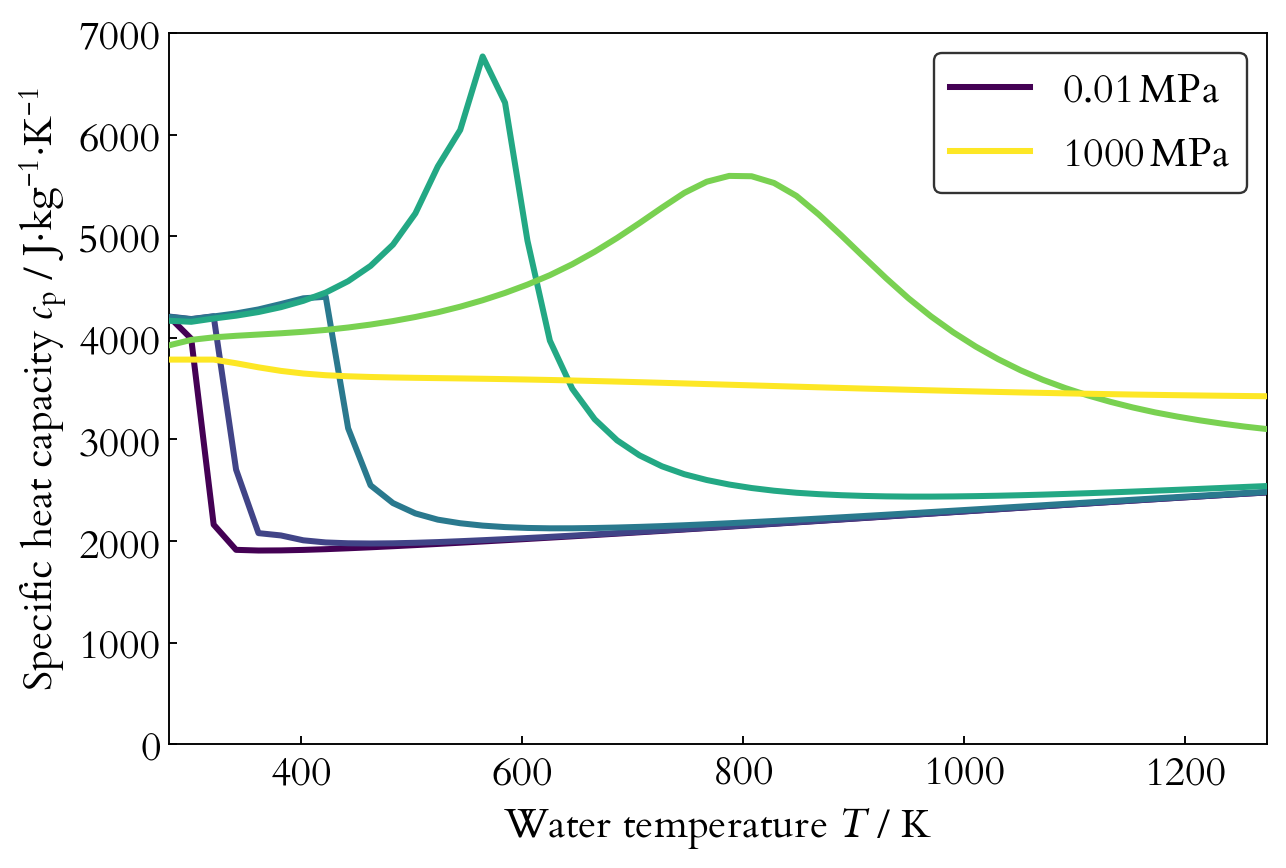

In [18]:
autofig("iapws-heat-capacity", Normal) do
    Ts = linspace(280, 1274)
    Ps = 10.0 .^ (-2:3) * 1e6
    N = length(Ps)
    heatcapacity = WaterData.load_heat_capacity()["heatcap_h2o"]
    cs = [heatcapacity(P, T) for T in Ts, P in Ps]

    colors = seqcolors(:viridis, N)

    plot(Ts, cs, label="", palette=colors, framestyle = :box)
    xaxis!(L"Water temperature $T$ / K", extrema(Ts))
    yaxis!(L"Specific heat capacity $c_\mathrm{p}$ / J$⋅$kg$^{-1}⋅$K$^{-1}$", (0, 7000))
    plot!([-99], [-99], label=L"0.01$\,$MPa", c=colors[1])
    plot!([-99], [-99], label=L"1000$\,$MPa", c=colors[N])
end;